## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to eb applied on the OpenMV camera.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 

Load MNIST dataset and split in training and test

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (6031, 28, 28)
     Test dataset higher than 6 has shape: (3969, 28, 28)


3.0


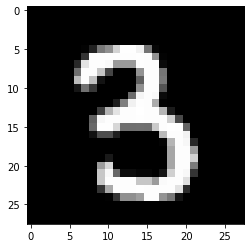

In [4]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,trainLow_samples))
plt.imshow(data_low_train[num], cmap="gray") # Import the image
print(label_low_train[num])
plt.show() # Plot the image

## **Pre process the data**

In [5]:
# Image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data_low_train = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Normalize the dataset

In [7]:
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **Build the model**

In [8]:
batch_size = 60
epochs     = 30
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [9]:
# METHOD 1
# Define the model architecture
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=input_shape),
#    tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
#    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(6, activation = "softmax")
#])

#model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [10]:
# METHOD 2
# Define the model architecture
model = Sequential()
model.add(Conv2D(filters=12, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(6, activation = "softmax"))

model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12174     
Total params: 12,294
Trainable params: 12,294
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(
    data_low_train,
    label_low_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.1
)

Epoch 1/30
541/541 [==============================] - 12s 23ms/step - loss: 1.1651 - accuracy: 0.9073 - val_loss: 1.0910 - val_accuracy: 0.9572
Epoch 2/30
541/541 [==============================] - 11s 20ms/step - loss: 1.0902 - accuracy: 0.9582 - val_loss: 1.0781 - val_accuracy: 0.9678
Epoch 3/30
541/541 [==============================] - 9s 16ms/step - loss: 1.0778 - accuracy: 0.9694 - val_loss: 1.0692 - val_accuracy: 0.9775
Epoch 4/30
541/541 [==============================] - 11s 20ms/step - loss: 1.0696 - accuracy: 0.9774 - val_loss: 1.0629 - val_accuracy: 0.9850
Epoch 5/30
541/541 [==============================] - 10s 19ms/step - loss: 1.0645 - accuracy: 0.9826 - val_loss: 1.0627 - val_accuracy: 0.9817
Epoch 6/30
541/541 [==============================] - 9s 17ms/step - loss: 1.0615 - accuracy: 0.9854 - val_loss: 1.0586 - val_accuracy: 0.9870
Epoch 7/30
541/541 [==============================] - 10s 19ms/step - loss: 1.0593 - accuracy: 0.9870 - val_loss: 1.0574 - val_accuracy: 0

In [13]:
# Evaluate the model performance
test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

189/189 [==============================] - 1s 4ms/step - loss: 1.0515 - accuracy: 0.9930

Test accuracy: 0.9930359721183777


# **Make predictions**

In [14]:
predictions = model.predict(data_low_test)   # Make prediction of entire dataset

In [15]:
num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

Prediction =  5
True label =  5.0


In [16]:
def plot_image(i, predictions_array, true_label, img):
    class_names = ['0','1','2','3','4','5']

    true_label, img = int(true_label[i]), img[i,:,:]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = (np.squeeze(img))## you have to delete the channel information (if grayscale) to plot the image
    plt.imshow(img, cmap="gray")

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)   


def plot_value_array(i, predictions_array, true_label):
    true_label = int(true_label[i])
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

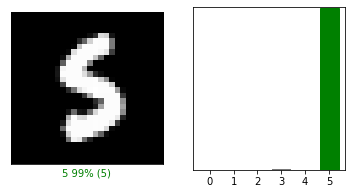

In [17]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **Save models**

In [18]:
def save_summary_model(model, MODEL_PATH, flag):
    new_file = open(MODEL_PATH + 'model_summary.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    if(flag==0):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the ORIGINAL MODEL")
    elif(flag==1):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the FROZEN MODEL")
    new_file.write("\n")
    new_file.write("\n Batch size:       " + str(batch_size))
    new_file.write("\n Epochs:           " + str(epochs))
    new_file.write("\n Metrics:          " + str(metrics))
    new_file.write("\n Optimizer:        " + optimizer)
    new_file.write("\n Loss:             " + "SparseCategoricalCrossentropy \n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [19]:
ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "\\Saved_models\\"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "\\Original_model\\"

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as mnist_cnn.h5')
model.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(model, ORIGINAL_MODEL_PATH, 0)

Test loss: 1.0514512062072754
Test accuracy: 0.9930359721183777
Save ORIGINAL MODEL as mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

In [20]:
# CREATE AND SAVE THE CUT MODEL
frozen_model = keras.models.Sequential(model.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "\\Frozen_model\\"

print('Save FROZEN MODEL model as mnist_cnn.h5')
model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(frozen_model, FROZEN_MODEL_PATH, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
Save FROZEN MODEL model as mnist_cnn.h5


Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [109]:
ll_weights = np.array(model.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# separate thhis file in lines of 
with open(FROZEN_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')



new_file.close()

# -------- BIASES
with open(FROZEN_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (2028, 6)
The shape of the last layer biases is: (6,)


In [120]:
ciccio = np.zeros((2028,10))


with open(FROZEN_MODEL_PATH + 'll_weights.txt') as weight_file:
    j,i = 0,0
    for line in weight_file:
        data = line.split(',')
        for numbers in data:
            ciccio[i,j] = float(numbers)
            i += 1

            if (i == 2028):
                i=0
                j+=1


In [123]:

print(ll_weights[0,0])
print(ll_weights[10,1])
print(ll_weights[157,3])
print(ll_weights[2000,5])

0.5364562
0.0037534148
0.3447123
-0.022823092


## **Quantization**

**Full integer quantization**

For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data.

In [22]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(data_low_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_io = converter.convert()
with open("mnist_quant_io.tflite", 'wb') as f:
    f.write(tflite_model_quant_io)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmpy80xszp9\assets


**Integer with float fallback (using default float input/output)**

In [23]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(data_low_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()
with open("mnist_quant.tflite", 'wb') as f:
    f.write(tflite_model_quant)

INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmpbzeelk_o\assets


INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmpbzeelk_o\assets


In [24]:
#representative_data_gen()